In [1]:
import os
import time
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

from multiprocessing.dummy import Pool as ThreadPool
# Turn interactive plotting off
plt.ioff()

from models import *

DEBUG = True                   # Output each main function runtime
SAVE_DATA = True                # Flag to save data below (dataframe + plots)
# PATH = r'C:\Users\Владислав\Downloads\Transport-networks-main'ё  # Base path (existing) where subfolder with results will be created
# PATH = r'C:\Users\va\Documents\Transport-networks'

PATH = '/home/sergey/projects/gasnich/Transport-networks'

# 1 person = 100 people
init_transmitters_num = 2      # Initial infected people number

timer_min = 12                   # Min steps (epochs) until infected person can transmit a disease (exception: initial group)
timer_max = 27                  # Max steps (epochs) until infected person can transmit a disease (exception: initial group)
transmission_time = 42          # Disease lifespan

# 1 distance point = 100 meters
neighbourhood_radius = 4        # Maximum distance allowed to travel for each person from his initial location

# 1 epoch = 8 hours
epochs = 600                    # Steps to perform during each people 1) travel and 2) spread the disease

radius = 3                      # Maximum radius for person to travel in single epoch
spread_radius = 1               # Disease spreading radius
infect_prob = 0.15              # Base probability for disease to transmit
death_prob = 0.02               # Death probability after disease

# (x, z, S, j, u)
transmitters_test_quota = 1     # Number of tests for visible transmitters to have possibility to move to quarantine zone with less death rate
others_test_quota = 10000       # Number of tests for others to have possibility to move to quarantine zone with less death rate
quarantine_zone_size = 300      # Quarantine zone's capacity
remote_workers = 0.5            # Fraction of remote workers
responsible_people = 0.5       # Fraction of responsible people (which have lower probability of getting ill)

# Path to plot of disease (exposure) matrix before transmitting a disease in each epoch
plot_disease_matrix = os.path.join(PATH, 'radius_{}_spread_radius_{}_infected_prob_{}'.format(str(radius).replace('.', '_'),
                                                                                           str(spread_radius).replace('.', '_'),
                                                                                           str(infect_prob).replace('.', '_')))
# Create this subfolder
try:
    os.mkdir(plot_disease_matrix)
except FileExistsError:
    pass

num_threads = 12

# Perform simulation (without city plots in each epoch)
timer_dict, healthy_tracker, infected_tracker, invisible_transmitters_tracker, \
transmitters_tracker, cured_tracker, dead_tracker, quarantine_tracker = simulate_transportations_with_infections(init_transmitters_num, \
                                                                                                remote_workers, \
                                                                                                responsible_people, \
                                                                                                timer_min, \
                                                                                                timer_max, \
                                                                                                transmission_time, \
                                                                                                neighbourhood_radius, \
                                                                                                infect_prob, \
                                                                                                death_prob, \
                                                                                                radius, \
                                                                                                spread_radius, \
                                                                                                quarantine_zone_size, \
                                                                                                transmitters_test_quota, \
                                                                                                others_test_quota, \
                                                                                                epochs, \
                                                                                                DEBUG, \
                                                                                                None,
                                                                                                num_threads=num_threads)



  0%|          | 0/600 [00:00<?, ?it/s]

radiuses 3 4
resp.sum 0
resp.sum 0
	walk_iter()			4.01 sec.
	make_disease_matrices()		0.00 sec.


  0%|          | 1/600 [00:05<54:45,  5.49s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=1]	infected=1	transmitters(visible+invisible)=2


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.13 sec.
	make_disease_matrices()		0.00 sec.


  0%|          | 2/600 [00:11<54:52,  5.51s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=2]	infected=1	transmitters(visible+invisible)=2


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.35 sec.
	make_disease_matrices()		0.00 sec.


  0%|          | 3/600 [00:16<55:24,  5.57s/it]

	spread_disease()		1.36 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=3]	infected=2	transmitters(visible+invisible)=2


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.45 sec.
	make_disease_matrices()		0.00 sec.


  1%|          | 4/600 [00:22<56:53,  5.73s/it]

	spread_disease()		1.63 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=4]	infected=3	transmitters(visible+invisible)=2


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.68 sec.
	make_disease_matrices()		0.00 sec.


  1%|          | 5/600 [00:29<58:10,  5.87s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=5]	infected=4	transmitters(visible+invisible)=2


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.50 sec.
	make_disease_matrices()		0.00 sec.


  1%|          | 6/600 [00:35<58:29,  5.91s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=6]	infected=5	transmitters(visible+invisible)=2


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.52 sec.
	make_disease_matrices()		0.00 sec.


  1%|          | 7/600 [00:41<58:41,  5.94s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=7]	infected=6	transmitters(visible+invisible)=2


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.57 sec.
	make_disease_matrices()		0.00 sec.


  1%|▏         | 8/600 [00:47<58:52,  5.97s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=8]	infected=6	transmitters(visible+invisible)=2


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.49 sec.
	make_disease_matrices()		0.00 sec.


  2%|▏         | 9/600 [00:53<58:53,  5.98s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=9]	infected=7	transmitters(visible+invisible)=2


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.74 sec.
	make_disease_matrices()		0.00 sec.


  2%|▏         | 10/600 [00:59<59:36,  6.06s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=10]	infected=7	transmitters(visible+invisible)=2


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.57 sec.
	make_disease_matrices()		0.00 sec.


  2%|▏         | 11/600 [01:05<59:30,  6.06s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=11]	infected=8	transmitters(visible+invisible)=2


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.52 sec.
	make_disease_matrices()		0.00 sec.


  2%|▏         | 12/600 [01:11<59:14,  6.05s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=12]	infected=9	transmitters(visible+invisible)=2


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.58 sec.
	make_disease_matrices()		0.00 sec.


  2%|▏         | 13/600 [01:17<59:18,  6.06s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=13]	infected=9	transmitters(visible+invisible)=2


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.55 sec.
	make_disease_matrices()		0.01 sec.


  2%|▏         | 14/600 [01:23<59:38,  6.11s/it]

	spread_disease()		1.64 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=14]	infected=10	transmitters(visible+invisible)=2


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.77 sec.
	make_disease_matrices()		0.00 sec.


  2%|▎         | 15/600 [01:30<1:00:03,  6.16s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=15]	infected=12	transmitters(visible+invisible)=2


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.48 sec.
	make_disease_matrices()		0.00 sec.


  3%|▎         | 16/600 [01:36<59:26,  6.11s/it]  

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=16]	infected=12	transmitters(visible+invisible)=2


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.51 sec.
	make_disease_matrices()		0.00 sec.


  3%|▎         | 17/600 [01:42<59:10,  6.09s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=17]	infected=12	transmitters(visible+invisible)=2


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.52 sec.
	make_disease_matrices()		0.00 sec.


  3%|▎         | 18/600 [01:48<58:45,  6.06s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=18]	infected=12	transmitters(visible+invisible)=2


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.48 sec.
	make_disease_matrices()		0.00 sec.


  3%|▎         | 19/600 [01:54<58:25,  6.03s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=19]	infected=12	transmitters(visible+invisible)=2


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.49 sec.
	make_disease_matrices()		0.00 sec.


  3%|▎         | 20/600 [01:59<58:08,  6.01s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=20]	infected=12	transmitters(visible+invisible)=2


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.50 sec.
	make_disease_matrices()		0.00 sec.


  4%|▎         | 21/600 [02:06<58:03,  6.02s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=21]	infected=13	transmitters(visible+invisible)=2


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.49 sec.
	make_disease_matrices()		0.00 sec.


  4%|▎         | 22/600 [02:11<57:53,  6.01s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=22]	infected=13	transmitters(visible+invisible)=3


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.54 sec.
	make_disease_matrices()		0.00 sec.


  4%|▍         | 23/600 [02:18<57:53,  6.02s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=23]	infected=14	transmitters(visible+invisible)=4


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.54 sec.
	make_disease_matrices()		0.00 sec.


  4%|▍         | 24/600 [02:24<57:56,  6.04s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=24]	infected=13	transmitters(visible+invisible)=6


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.55 sec.
	make_disease_matrices()		0.00 sec.


  4%|▍         | 25/600 [02:30<57:56,  6.05s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=25]	infected=16	transmitters(visible+invisible)=7


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.52 sec.
	make_disease_matrices()		0.00 sec.


  4%|▍         | 26/600 [02:36<57:43,  6.03s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=26]	infected=20	transmitters(visible+invisible)=7


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.49 sec.
	make_disease_matrices()		0.00 sec.


  4%|▍         | 27/600 [02:42<57:31,  6.02s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=27]	infected=22	transmitters(visible+invisible)=7


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.53 sec.
	make_disease_matrices()		0.00 sec.


  5%|▍         | 28/600 [02:48<57:29,  6.03s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=28]	infected=22	transmitters(visible+invisible)=7


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.54 sec.
	make_disease_matrices()		0.00 sec.


  5%|▍         | 29/600 [02:54<57:49,  6.08s/it]

	spread_disease()		1.62 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=29]	infected=21	transmitters(visible+invisible)=9


radiuses 3 4
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.56 sec.
	make_disease_matrices()		0.00 sec.


  5%|▌         | 30/600 [03:00<57:46,  6.08s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=30]	infected=21	transmitters(visible+invisible)=9


radiuses 3 4
resp.sum 11171
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.55 sec.
	make_disease_matrices()		0.00 sec.


  5%|▌         | 31/600 [03:06<57:38,  6.08s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=31]	infected=22	transmitters(visible+invisible)=9


radiuses 3 4
resp.sum 11171
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.50 sec.
	make_disease_matrices()		0.00 sec.


  5%|▌         | 32/600 [03:12<57:18,  6.05s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=32]	infected=21	transmitters(visible+invisible)=10


radiuses 3 4
resp.sum 11171
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.48 sec.
	make_disease_matrices()		0.00 sec.


  6%|▌         | 33/600 [03:18<56:58,  6.03s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=33]	infected=19	transmitters(visible+invisible)=12


radiuses 3 4
resp.sum 11171
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.49 sec.
	make_disease_matrices()		0.00 sec.


  6%|▌         | 34/600 [03:24<56:53,  6.03s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=34]	infected=20	transmitters(visible+invisible)=12


radiuses 3 4
resp.sum 11171
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.58 sec.
	make_disease_matrices()		0.00 sec.


  6%|▌         | 35/600 [03:30<57:03,  6.06s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=35]	infected=22	transmitters(visible+invisible)=12


radiuses 3 4
resp.sum 11171
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.54 sec.
	make_disease_matrices()		0.00 sec.


  6%|▌         | 36/600 [03:36<56:53,  6.05s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=36]	infected=22	transmitters(visible+invisible)=12


radiuses 3 4
resp.sum 11171
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.51 sec.
	make_disease_matrices()		0.00 sec.


  6%|▌         | 37/600 [03:42<56:38,  6.04s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=37]	infected=19	transmitters(visible+invisible)=15


radiuses 3 4
resp.sum 11171
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.48 sec.
	make_disease_matrices()		0.00 sec.


  6%|▋         | 38/600 [03:48<56:18,  6.01s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=38]	infected=18	transmitters(visible+invisible)=17


radiuses 3 4
resp.sum 11171
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			4.80 sec.
	make_disease_matrices()		0.01 sec.


  6%|▋         | 39/600 [03:55<57:51,  6.19s/it]

	spread_disease()		1.78 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=39]	infected=20	transmitters(visible+invisible)=17


radiuses 1 1
resp.sum 11171
resp.sum 63390
	decrement_timers()		0.00 sec.
	walk_iter()			38.37 sec.
	make_disease_matrices()		0.01 sec.


  7%|▋         | 40/600 [04:35<2:32:18, 16.32s/it]

	spread_disease()		1.56 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=40]	infected=21	transmitters(visible+invisible)=18


radiuses 1 1
resp.sum 11171
resp.sum 63390
	decrement_timers()		0.00 sec.
	walk_iter()			2.07 sec.
	make_disease_matrices()		0.00 sec.


  7%|▋         | 41/600 [04:38<1:56:40, 12.52s/it]

	spread_disease()		1.57 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=41]	infected=25	transmitters(visible+invisible)=18


radiuses 1 1
resp.sum 11171
resp.sum 63390
	decrement_timers()		0.00 sec.
	walk_iter()			2.50 sec.
	make_disease_matrices()		0.00 sec.


  7%|▋         | 42/600 [04:43<1:32:58, 10.00s/it]

	spread_disease()		1.57 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=42]	infected=25	transmitters(visible+invisible)=19


radiuses 1 1
resp.sum 11171
resp.sum 63390
	decrement_timers()		0.00 sec.
	walk_iter()			2.41 sec.
	make_disease_matrices()		0.00 sec.


  7%|▋         | 43/600 [04:46<1:15:59,  8.19s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=43]	infected=25	transmitters(visible+invisible)=19


radiuses 1 1
resp.sum 0
resp.sum 63390
	decrement_timers()		0.00 sec.
	walk_iter()			2.32 sec.
	make_disease_matrices()		0.00 sec.


  7%|▋         | 44/600 [04:50<1:04:08,  6.92s/it]

	spread_disease()		1.63 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=44]	infected=26	transmitters(visible+invisible)=19


radiuses 1 1
resp.sum 0
resp.sum 63390
	decrement_timers()		0.01 sec.
	walk_iter()			2.48 sec.
	make_disease_matrices()		0.00 sec.


  8%|▊         | 45/600 [04:55<56:07,  6.07s/it]  

	spread_disease()		1.57 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=45]	infected=26	transmitters(visible+invisible)=20


radiuses 1 1
resp.sum 0
resp.sum 63390
	decrement_timers()		0.00 sec.
	walk_iter()			2.31 sec.
	make_disease_matrices()		0.00 sec.


  8%|▊         | 46/600 [04:58<49:51,  5.40s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=46]	infected=26	transmitters(visible+invisible)=22


radiuses 1 1
resp.sum 0
resp.sum 63390
	decrement_timers()		0.00 sec.
	walk_iter()			2.50 sec.
	make_disease_matrices()		0.00 sec.


  8%|▊         | 47/600 [05:02<46:11,  5.01s/it]

	spread_disease()		1.58 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=47]	infected=26	transmitters(visible+invisible)=22


radiuses 1 1
resp.sum 0
resp.sum 63390
	decrement_timers()		0.00 sec.
	walk_iter()			2.44 sec.
	make_disease_matrices()		0.00 sec.


  8%|▊         | 48/600 [05:07<43:29,  4.73s/it]

	spread_disease()		1.60 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=48]	infected=28	transmitters(visible+invisible)=22


radiuses 1 1
resp.sum 0
resp.sum 63390
	decrement_timers()		0.00 sec.
	walk_iter()			2.43 sec.
	make_disease_matrices()		0.00 sec.


  8%|▊         | 49/600 [05:11<41:41,  4.54s/it]

	spread_disease()		1.65 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=49]	infected=27	transmitters(visible+invisible)=24


radiuses 1 1
resp.sum 7930
resp.sum 63390
	decrement_timers()		0.00 sec.
	walk_iter()			2.41 sec.
	make_disease_matrices()		0.00 sec.


  8%|▊         | 50/600 [05:15<40:19,  4.40s/it]

	spread_disease()		1.64 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=50]	infected=25	transmitters(visible+invisible)=26


radiuses 1 1
resp.sum 7930
resp.sum 63390
	decrement_timers()		0.00 sec.
	walk_iter()			2.33 sec.
	make_disease_matrices()		0.00 sec.


  8%|▊         | 51/600 [05:19<39:01,  4.27s/it]

	spread_disease()		1.60 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=51]	infected=22	transmitters(visible+invisible)=29


radiuses 1 1
resp.sum 13629
resp.sum 63390
	decrement_timers()		0.00 sec.
	walk_iter()			2.36 sec.
	make_disease_matrices()		0.01 sec.


  9%|▊         | 52/600 [05:23<38:11,  4.18s/it]

	spread_disease()		1.60 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=52]	infected=20	transmitters(visible+invisible)=32


radiuses 1 1
resp.sum 13629
resp.sum 63390
	decrement_timers()		0.00 sec.
	walk_iter()			2.39 sec.
	make_disease_matrices()		0.00 sec.


  9%|▉         | 53/600 [05:27<37:36,  4.13s/it]

	spread_disease()		1.58 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=53]	infected=19	transmitters(visible+invisible)=33


radiuses 1 1
resp.sum 13629
resp.sum 63390
	decrement_timers()		0.00 sec.
	walk_iter()			2.38 sec.
	make_disease_matrices()		0.00 sec.


  9%|▉         | 54/600 [05:31<37:31,  4.12s/it]

	spread_disease()		1.71 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=54]	infected=17	transmitters(visible+invisible)=35


radiuses 1 1
resp.sum 15676
resp.sum 63390
	decrement_timers()		0.00 sec.
	walk_iter()			2.64 sec.
	make_disease_matrices()		0.01 sec.


  9%|▉         | 55/600 [05:35<38:02,  4.19s/it]

	spread_disease()		1.67 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=55]	infected=17	transmitters(visible+invisible)=35


radiuses 1 1
resp.sum 15676
resp.sum 63390
	decrement_timers()		0.00 sec.
	walk_iter()			2.40 sec.
	make_disease_matrices()		0.00 sec.


  9%|▉         | 56/600 [05:39<37:36,  4.15s/it]

	spread_disease()		1.64 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=56]	infected=19	transmitters(visible+invisible)=35


radiuses 1 1
resp.sum 17459
resp.sum 63390
	decrement_timers()		0.00 sec.
	walk_iter()			2.60 sec.
	make_disease_matrices()		0.00 sec.


 10%|▉         | 57/600 [05:43<37:56,  4.19s/it]

	spread_disease()		1.68 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=57]	infected=20	transmitters(visible+invisible)=36


radiuses 1 1
resp.sum 17459
resp.sum 63390
	decrement_timers()		0.00 sec.
	walk_iter()			2.60 sec.
	make_disease_matrices()		0.00 sec.


 10%|▉         | 58/600 [05:48<37:52,  4.19s/it]

	spread_disease()		1.57 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=58]	infected=16	transmitters(visible+invisible)=42


radiuses 1 1
resp.sum 19052
resp.sum 63390
	decrement_timers()		0.00 sec.
	walk_iter()			2.60 sec.
	make_disease_matrices()		0.00 sec.


 10%|▉         | 59/600 [05:52<38:06,  4.23s/it]

	spread_disease()		1.67 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=59]	infected=16	transmitters(visible+invisible)=43


radiuses 1 1
resp.sum 20499
resp.sum 63390
	decrement_timers()		0.00 sec.
	walk_iter()			2.71 sec.
	make_disease_matrices()		0.01 sec.


 10%|█         | 60/600 [05:56<38:27,  4.27s/it]

	spread_disease()		1.65 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=60]	infected=15	transmitters(visible+invisible)=44


radiuses 1 1
resp.sum 21830
resp.sum 63390
	decrement_timers()		0.00 sec.
	walk_iter()			2.30 sec.
	make_disease_matrices()		0.00 sec.


 10%|█         | 61/600 [06:00<37:38,  4.19s/it]

	spread_disease()		1.67 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=61]	infected=15	transmitters(visible+invisible)=45


radiuses 1 1
resp.sum 23066
resp.sum 63390
	decrement_timers()		0.01 sec.
	walk_iter()			2.51 sec.
	make_disease_matrices()		0.00 sec.


 10%|█         | 62/600 [06:05<37:33,  4.19s/it]

	spread_disease()		1.65 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=62]	infected=15	transmitters(visible+invisible)=46


radiuses 1 1
resp.sum 23066
resp.sum 63390
	decrement_timers()		0.01 sec.
	walk_iter()			2.59 sec.
	make_disease_matrices()		0.00 sec.


Process ForkPoolWorker-4:
Process ForkPoolWorker-5:
Process ForkPoolWorker-11:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-10:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File

  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/sergey/projects/gasnich/Transport-networks/disease.py", line 106, in spread_disease_observed_indexes
    replace=False)
  File "<__array_function__ internals>", line 2, in count_nonzero
  File "<__array_function__ internals>", line 2, in unique
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "mtrand.pyx", line 967, in numpy.random.mtrand.RandomState.choice
KeyboardInterrupt
  File "<__array_function__ internals>", line 6, in unique
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/sergey/projects/gasnich/Transport-networks/disease.py", line 102, in spread_disease_observed_indexes
    infection_prob = calc_infection_prob(infection_exposure, infect_prob)
  File "/home/sergey/projects/gasnich/Transport-networks/disease.py", line 89, in calc_infection_prob
    return 1 - (1 - infect_prob

KeyboardInterrupt: 

In [4]:
def real_data_preparation(mos_odl_data_name, mos_data_name, start_day=12, epoch_scale=3, people_scale=0.01):
    mos_obl_data = pd.read_csv(mos_odl_data_name)
    mos_data = pd.read_csv(mos_data_name)
    mos_obl_cum_cases = mos_obl_data.values[:,3:].sum(-1)
    mos_obl_cum_dates = mos_obl_data.values[:,2]
    mos_dates = mos_data.values[:,-1]
    # mos_data = mos_data.values[:,1]
    mos_dates
    observed_dates = set([i for i in mos_obl_cum_dates if i in mos_dates])
    mos_observed_indexes = np.arange(mos_dates.shape[0])[np.array([i in observed_dates for i in mos_dates])]
    mos_obl_obs_index_list = []
    for i in observed_dates:
        for n, j in enumerate(mos_obl_cum_dates):
            if j == i:
                mos_obl_obs_index_list += [n]
                break
    # mos_obl_observed_indexes = np.arange(mos_obl_cum_dates.shape[0])[np.array([i in observed_dates for i in mos_obl_cum_dates])]
    mos_and_obl_cum_data = mos_data.values[:,1][mos_observed_indexes] + mos_obl_cum_cases[np.array(mos_obl_obs_index_list)]
    observed_epoch = (np.sort(np.array(list(observed_dates))) - min(observed_dates) + start_day) * epoch_scale
    return (mos_and_obl_cum_data * people_scale).astype(np.int), observed_epoch


mos_odl_data_name = 'mos_obl_data.csv'
mos_data_name = 'mos_data.csv'
real_cases, real_epoch = real_data_preparation(mos_odl_data_name, mos_data_name)

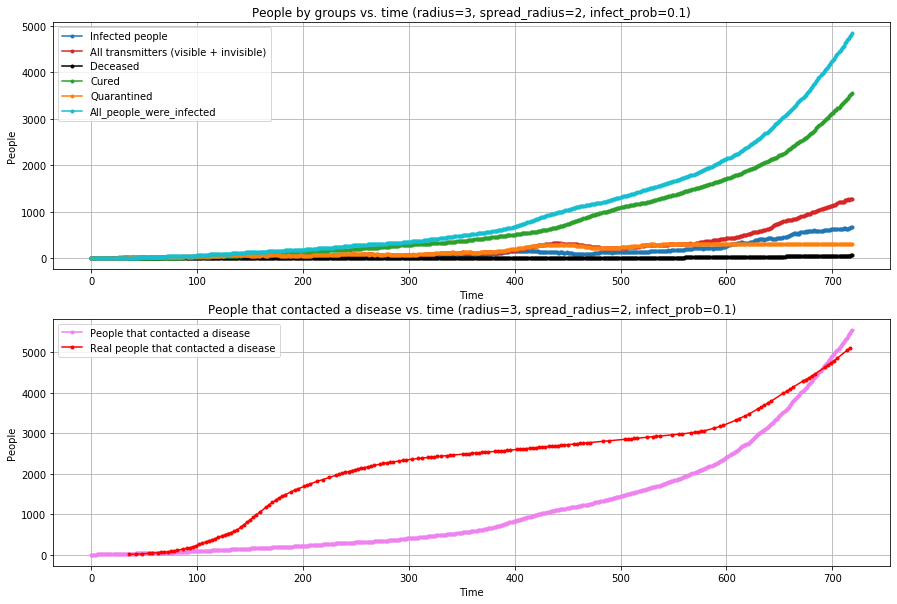

In [5]:
# Save detailed stats
df = pd.DataFrame(np.array([healthy_tracker, infected_tracker, invisible_transmitters_tracker, \
                            transmitters_tracker, cured_tracker, dead_tracker, quarantine_tracker]).T,
                  columns=['healthy', 'infected', 'invisible_transmitters', 'transmitters', 'cured', 'dead', 'quarantined'])
if SAVE_DATA:
    df.to_csv(os.path.join(plot_disease_matrix, 'stats.csv'), sep='\t')

# Save progress plot
fig, ax = plt.subplots(nrows=2, figsize=(15, 2 * 5))

ax[0].plot(infected_tracker, '.-', c='tab:blue', label='Infected people')
ax[0].plot(invisible_transmitters_tracker + transmitters_tracker, '.-', c='tab:red', label='All transmitters (visible + invisible)')
ax[0].plot(dead_tracker, '.-', c='black', label='Deceased')
ax[0].plot(cured_tracker, '.-', c='tab:green', label='Cured')
ax[0].plot(quarantine_tracker, '.-', c='tab:orange', label='Quarantined')
ax[0].plot(invisible_transmitters_tracker + transmitters_tracker + cured_tracker, '.-', c='tab:cyan', label='All_people_were_infected')

ax[0].set_ylabel('People')
ax[0].set_xlabel('Time')
ax[0].set_title(f'People by groups vs. time (radius={radius}, spread_radius={spread_radius}, infect_prob={infect_prob})')
ax[0].grid()
ax[0].legend()

ax[1].plot(infected_tracker + invisible_transmitters_tracker + transmitters_tracker + dead_tracker + cured_tracker, '.-',
           c='violet', label='People that contacted a disease')

ax[1].set_ylabel('People')
ax[1].set_xlabel('Time')
ax[1].set_title(f'People that contacted a disease vs. time (radius={radius}, spread_radius={spread_radius}, infect_prob={infect_prob})')
ax[1].plot(real_epoch[:np.searchsorted(real_epoch, len(infected_tracker))], real_cases[:np.searchsorted(real_epoch, len(infected_tracker))], '.-', c='red', label='Real people that contacted a disease')
ax[1].grid()
ax[1].legend()

if SAVE_DATA:
    fig.savefig(os.path.join(plot_disease_matrix, 'stats_ts.png'), dpi=300);

plt.show()